In [678]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import re
from wordfreq import zipf_frequency

In [302]:
# read DGA and Cisco high confidence data
dga_df = pd.read_csv('..\\data\\2018_0923\\dga-feed-high.csv', header=None, skiprows=15)
cisco_df = pd.read_csv('..\\data\\2018_0923\\top-1m.csv', header=None)

In [303]:
# display head
def display_df(dga_df_, cisco_df_):
    display("DGA feed sample: {}".format( dga_df_.shape) )
    display(dga_df_.head())
    display("Cisco feed sample: {}".format( cisco_df_.shape) )
    display(cisco_df_.head())

display_df(dga_df, cisco_df)
print(dga_df.shape)

'DGA feed sample: (381953, 4)'

,0,1,2,3
0,plvklpgwivery.com,Domain used by Cryptolocker - Flashback DGA fo...,2018-06-23,http://osint.bambenekconsulting.com/manual/cl.txt
1,dnuxdhcgblsgy.net,Domain used by Cryptolocker - Flashback DGA fo...,2018-06-23,http://osint.bambenekconsulting.com/manual/cl.txt
2,qjlullhfkiowp.biz,Domain used by Cryptolocker - Flashback DGA fo...,2018-06-23,http://osint.bambenekconsulting.com/manual/cl.txt
3,elkidddodxdly.ru,Domain used by Cryptolocker - Flashback DGA fo...,2018-06-23,http://osint.bambenekconsulting.com/manual/cl.txt
4,rnbfwuprlwfor.org,Domain used by Cryptolocker - Flashback DGA fo...,2018-06-23,http://osint.bambenekconsulting.com/manual/cl.txt


'Cisco feed sample: (1000000, 2)'

,0,1
0,1,netflix.com
1,2,api-global.netflix.com
2,3,prod.netflix.com
3,4,push.prod.netflix.com
4,5,google.com


(381953, 4)


In [304]:
# remove unused columns, add otuput label 'dga'
dga_df_slim =   dga_df.drop(columns=range(1,dga_df.shape[1]), inplace=False)
dga_df_slim.columns = ['domain']
cisco_df_slim = cisco_df.drop(columns=[0], inplace=False)
cisco_df_slim.columns = ['domain']
dga_df_slim['dga'] = 1
cisco_df_slim['dga'] = 0

display_df(dga_df_slim, cisco_df_slim)
unified_df = pd.concat([cisco_df_slim, dga_df_slim], ignore_index=True)
unified_df['scoreMetrics'] = None
unified_df.head()

'DGA feed sample: (381953, 2)'

,domain,dga
0,plvklpgwivery.com,1
1,dnuxdhcgblsgy.net,1
2,qjlullhfkiowp.biz,1
3,elkidddodxdly.ru,1
4,rnbfwuprlwfor.org,1


'Cisco feed sample: (1000000, 2)'

,domain,dga
0,netflix.com,0
1,api-global.netflix.com,0
2,prod.netflix.com,0
3,push.prod.netflix.com,0
4,google.com,0


,domain,dga,scoreMetrics
0,netflix.com,0,None
1,api-global.netflix.com,0,None
2,prod.netflix.com,0,None
3,push.prod.netflix.com,0,None
4,google.com,0,None


In [819]:
# Functions to score the text - domain, or lables, and its segments

NA_score = 200.0                                   # penalty score of a text not in vocabulary
BIGRAM_score = 100.0                                # penalty score for bigram

all_alphas = set(string.ascii_lowercase)
valid_unigrams = set([])
#valid_unigrams = set(['a', 'i', 'u'])
invalid_unigrams = all_alphas - valid_unigrams

def scoreTextSegment(iStart, iStop, text):
    """ returns the score of a segment of text agaist the word frequency
    
    Args:
        iStart: starting index within the input text
        iStop:  starting index within the input text
        text:   input text
    Returns:
        log probability score of the text segment
    """
    global invalid_unigrams
    global NA_score
    
    if text[iStart:iStop] in invalid_unigrams:
        return NA_score
    elif iStop-iStart == 2:
        return BIGRAM_score
    else:
        act_freq = zipf_frequency(text[iStart:iStop], 'en', 'small')
        if act_freq == 0.0:
            return NA_score
        else:
            return act_freq

def scoreBestSegments(input_text, verbosity=0, scoreFn=scoreTextSegment):
    """optionally split the text to determine cutpoints for highest scoring

    Args:
      input_text: input text to segment
      scoreFn:    a function that accepts "start" and "stop" segments of the text
                  and gives back the score of the segment extending from [start, stop)
    
    Returns:
      The best score determined from segmentation.
    """
    n = len(input_text)
    leftScore = []
    distinct_segs = set()

    for k in range(n + 1):
        leftScore.append((scoreFn(0, k, input_text), []))
        last_idx = 0
        
        for j in range(k):
            
            newScore = leftScore[j][0] + scoreFn(j, k, input_text)
            if( newScore <  leftScore[k][0] ):
                
                if verbosity >= 4:
                    print("For K ={:2d} found better split at: {:2d}, Old : {:10.2f} New =  {:10.2f}, {:s}"
                          .format(k,j, leftScore[k][0], newScore, input_text[last_idx:j]))
                
                leftScore[k] = ( newScore, leftScore[j][1] + [j] )
                last_idx = j
        
        if verbosity >= 4:
            print("Final split for K= {:2d} = {}\n".format(k, leftScore[k][1]))
    
    last_idx = 0
    for i in leftScore[n][1]:
        distinct_segs.update([(input_text[last_idx:i])])
        last_idx = i
    distinct_segs.update([input_text[last_idx:]])

    return leftScore[n][0], leftScore[n][1], distinct_segs



In [820]:
# extracting DGA category
#PREFIX = ['Domain used by ']
#SUFFIX = ['DGA', '(', 'for']
#
#def extract_DGAcat(catText):
#    dga_cat = catText.strip(i) for i in PREFIX
#    for i in SUFFIX:
#        

In [821]:
# Printing functions

def segment_and_print(inpText, verbosity=0):
    """Prints the segments of text
       
       Args:
           text: input text to optimally segment
        
       Returns:
           text segmentation output
    """
    score, segment_list, dontcare = scoreBestSegments(inpText, verbosity=verbosity)
    last_idx = 0
    print("\nSegmented text for '{}':".format(inpText))
    for idx in segment_list:
        print(inpText[last_idx:int(idx)], end=' ')
        last_idx = int(idx)
    print(inpText[last_idx:])

def print_segments(inpText, segment_list):
    """Prints the segments of text
       
       Args:
           text: input text to optimally segment
           segment_list: a list of boundary indices of the segments
        
       Returns:
           text segmentation output
    """
    last_idx = 0
    for idx in segment_list:
        print(inpText[last_idx:idx], end=' ')
        last_idx = idx
    print(inpText[last_idx:l])

In [822]:
# Wrapper function for scoring domain 

def scoreDomain(inRow, verbosity=0):
    """ Splits the domain by labels (dot separator) and
        optimally segments each label into words based on 
        word frequency (wordfreq) corpus.
        
        Args:
            inRow: input row of the domain dataframe
        
        Returns:
            score: scoring of the domain
    """
    thisDomain = inRow['domain']
    num_digits = sum( char.isdigit() for char in thisDomain)
    
    if verbosity >= 2:
        print("\n", "="*5, thisDomain, "="*5)
    
    
    labels = thisDomain.lower()
    #labels = labels.split('.')
    labels = re.split('\W+', labels)        # separate the domain labels
    #labels.pop(-1)                          # drop TLD label
    thisScore = []
    unique_words = set()
    for i,label in enumerate(labels):
        iScore, iSegs, word_set = scoreBestSegments(label, verbosity)
        thisScore.append(iScore)
        unique_words.update(word_set)
        if verbosity >= 2:
            print("Score for label '{:30s}' = {:6.3f}, unique_words = {:d} {}"
                  .format(label, thisScore[i], len(word_set), word_set))
    
    
    
    return [sum(thisScore),                      # return total score for the domain
            sum(thisScore) / len(thisDomain),    # total score normalized bu domain length
            len(unique_words),                   # return number of unique words in domain
            len(unique_words) / len(thisDomain), # return number of unique words in domain normalized by its length
            num_digits,
            num_digits / len(thisDomain)]
            
            

In [835]:
# Testing segmentation code
print("\n--Text segmentation--")
random_domain = 'globalvaluecommerce.com'
segment_and_print(random_domain, verbosity=1)

print("\n--Domain scoring--")
domain_name = 'ipv4-c001-hfa001-cellcom-isp.1.oca.nflxvideo.net'
another_domain = pd.DataFrame(domain_name, index=[0], columns=['domain'])
another_domain.apply( lambda row: scoreDomain(row, verbosity=2), axis=1 )


--Text segmentation--

Segmented text for 'globalvaluecommerce.com':
global value commerce .com

--Domain scoring--

 ===== ipv4-c001-hfa001-cellcom-isp.1.oca.nflxvideo.net =====
Score for label 'ipv4                          ' = 200.000, unique_words = 1 {'ipv4'}
Score for label 'c001                          ' =  3.190, unique_words = 1 {'c001'}
Score for label 'hfa001                        ' = 103.680, unique_words = 2 {'a001', 'hf'}
Score for label 'cellcom                       ' =  8.880, unique_words = 2 {'cell', 'com'}
Score for label 'isp                           ' =  3.270, unique_words = 1 {'isp'}
Score for label '1                             ' =  6.020, unique_words = 1 {'1'}
Score for label 'oca                           ' = 200.000, unique_words = 1 {'oca'}
Score for label 'nflxvideo                     ' = 11.040, unique_words = 3 {'nfl', 'deo', 'xvi'}
Score for label 'net                           ' =  4.750, unique_words = 1 {'net'}


0    [540.8299999999999, 11.267291666666665, 13, 0....
dtype: object

In [836]:
debug_verbose = 1
samples = 20000

sampled_df = unified_df
#sampled_df = unified_df.sample(n=samples, random_state=3)

if debug_verbose:
    display(sampled_df.head(5))

sampled_df.scoreMetrics = sampled_df.apply( lambda row: scoreDomain(row, verbosity=debug_verbose), axis=1 )

if debug_verbose:
    print("After scoring:\n")
    display(sampled_df.head(5))

,domain,dga,scoreMetrics
0,netflix.com,0,"[4.06, 0.3690909090909091, 1, 0.09090909090909..."
1,api-global.netflix.com,0,"[12.75, 0.5795454545454546, 3, 0.1363636363636..."
2,prod.netflix.com,0,"[7.18, 0.44875, 2, 0.125, 0, 0.0]"
3,push.prod.netflix.com,0,"[11.94, 0.5685714285714285, 3, 0.1428571428571..."
4,google.com,0,"[4.77, 0.477, 1, 0.1, 0, 0.0]"


After scoring:



,domain,dga,scoreMetrics
0,netflix.com,0,"[8.12, 0.7381818181818182, 2, 0.18181818181818..."
1,api-global.netflix.com,0,"[16.81, 0.764090909090909, 4, 0.18181818181818..."
2,prod.netflix.com,0,"[11.239999999999998, 0.7024999999999999, 3, 0...."
3,push.prod.netflix.com,0,"[16.0, 0.7619047619047619, 4, 0.19047619047619..."
4,google.com,0,"[8.829999999999998, 0.8829999999999998, 2, 0.2..."


In [837]:
# group score metrics by dga or non-dga 
sc_dga = sampled_df[sampled_df['dga']==1]['scoreMetrics']
display(sc_dga.head())
sc_nondga = sampled_df[sampled_df['dga']==0]['scoreMetrics']
display(sc_nondga.head())

1000000    [204.06, 12.003529411764706, 2, 0.117647058823...
1000001    [204.75, 12.044117647058824, 2, 0.117647058823...
1000002    [203.12, 11.948235294117648, 2, 0.117647058823...
1000003                     [300.0, 18.75, 2, 0.125, 0, 0.0]
1000004    [203.29, 11.958235294117646, 2, 0.117647058823...
Name: scoreMetrics, dtype: object

0    [8.12, 0.7381818181818182, 2, 0.18181818181818...
1    [16.81, 0.764090909090909, 4, 0.18181818181818...
2    [11.239999999999998, 0.7024999999999999, 3, 0....
3    [16.0, 0.7619047619047619, 4, 0.19047619047619...
4    [8.829999999999998, 0.8829999999999998, 2, 0.2...
Name: scoreMetrics, dtype: object

In [838]:
def retrieve_score( dframe, scoreIdx):
    return list(dframe.apply( lambda x: x[scoreIdx]))

In [860]:
def plot_hists(dga_df, nondga_df, scoreType=0, scoreText='', title=''):

    plt.figure(figsize=(12,8))
    dga_scores = retrieve_score(dga_df, scoreType)
    nondga_scores = retrieve_score(nondga_df, scoreType)
    plt.hist([dga_scores, nondga_scores], bins=20, color=['orange', 'skyblue'],
             label = ['DGA domains (bad)', 'non-DGA domains (good)'],
             histtype='bar')
    #plt.xticks(range(0, 500))
    #plt.yticks(range(1, 2000))
    plt.xlabel(scoreText)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True,'major')
    plt.title(title)
    plt.savefig('score_' + str(scoreType) + '.png')
    plt.show()

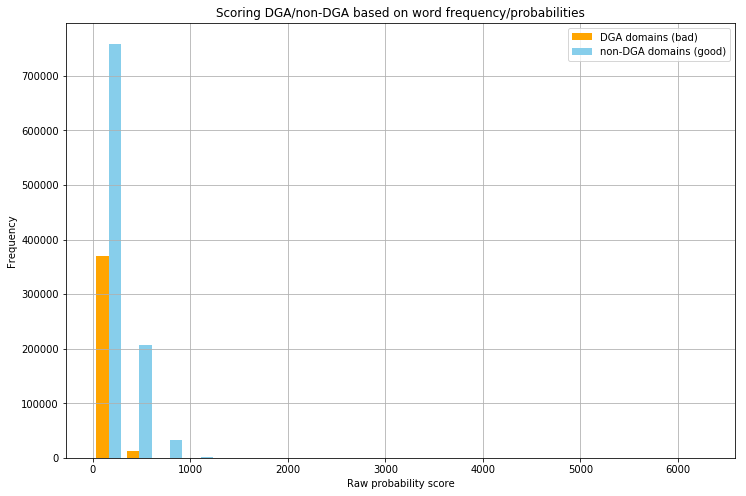

In [861]:
plot_hists(sc_dga, sc_nondga, 0, 'Raw probability score', 
           'Scoring DGA/non-DGA based on word frequency/probabilities')

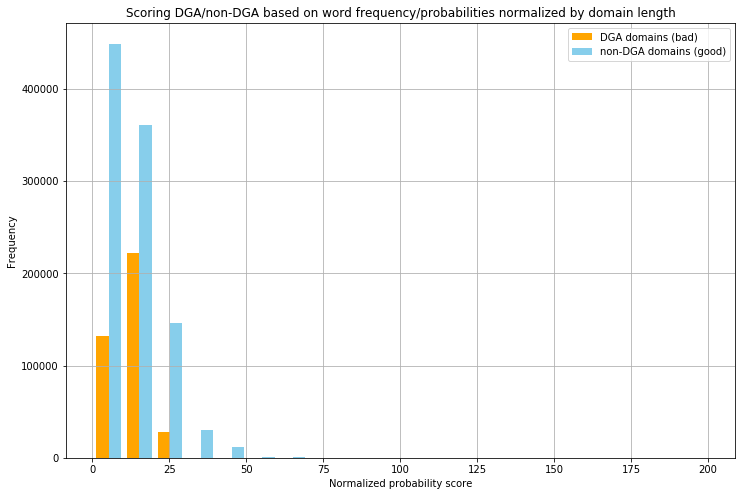

In [862]:
plot_hists(sc_dga, sc_nondga, 1, 'Normalized probability score', 
           'Scoring DGA/non-DGA based on word frequency/probabilities normalized by domain length')

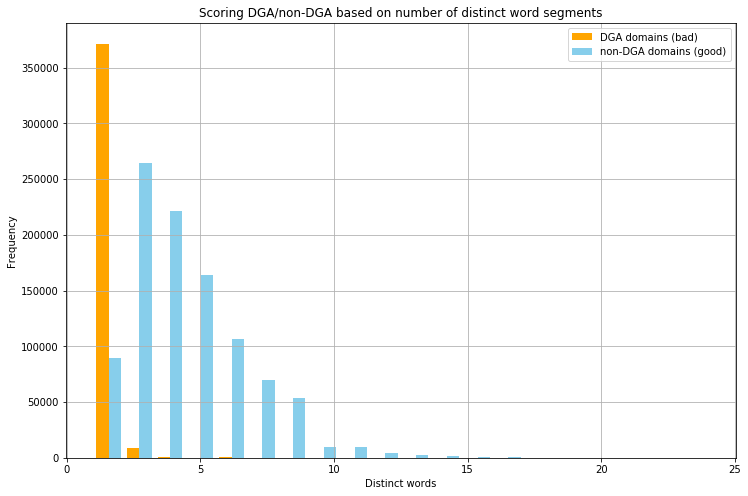

In [863]:
plot_hists(sc_dga, sc_nondga, 2, 'Distinct words', 
           'Scoring DGA/non-DGA based on number of distinct word segments')

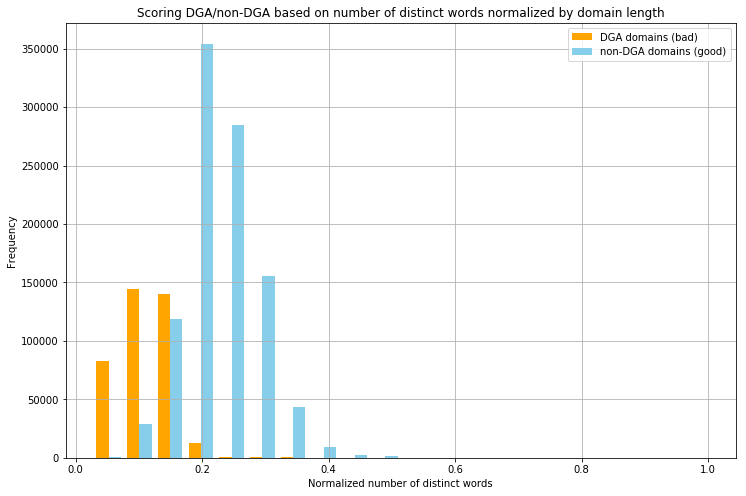

In [864]:
plot_hists(sc_dga, sc_nondga, 3, 'Normalized number of distinct words', 
           'Scoring DGA/non-DGA based on number of distinct words normalized by domain length')

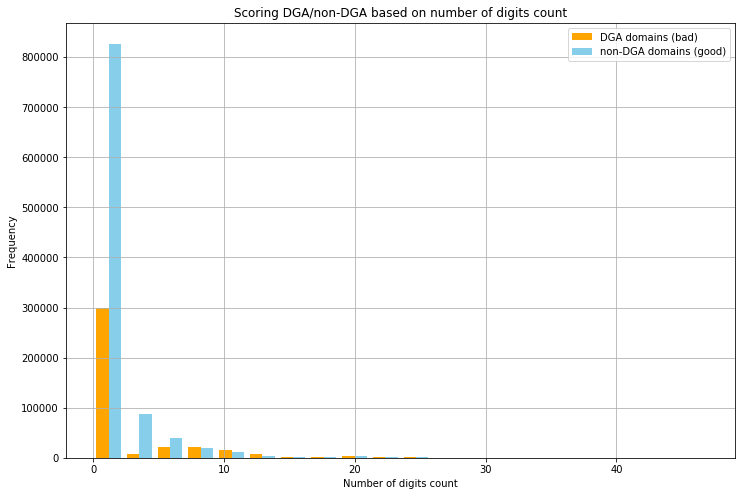

In [865]:
plot_hists(sc_dga, sc_nondga, 4, 'Number of digits count', 
           'Scoring DGA/non-DGA based on number of digits count')

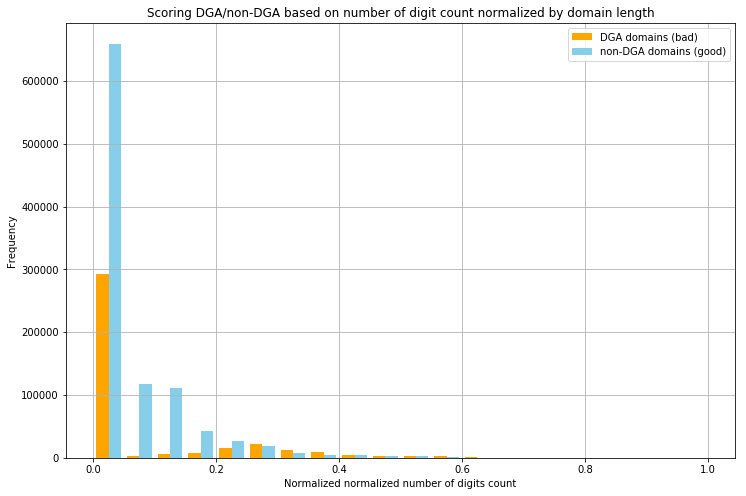

In [866]:
plot_hists(sc_dga, sc_nondga, 5, 'Normalized normalized number of digits count', 
           'Scoring DGA/non-DGA based on number of digit count normalized by domain length')

# Summary

So far the strongest signal appears to be in the number of distinct words in the domain name, normalized by the domain length.

The other metrics as 
1) raw/normalized scoring based on vocabulary contexts, 
2) raw count/normalized number of digit characters
in the domain name don't seem to offer any appreciable differentiation in the DGA vs non-DGA domains.